## Task 3: Finetuning an Automatic Speed Recognition (ASR) AI Model

This notebook presents my solutions for how I approached to fine-tune the pre-trained ```facebook/wav2vec2-large-960h``` model. The dataset used will be the Common Voice dataset as stated in the question in the folder directory ```data/cv-valid-train```

Before running any of the code, ensure that you have set up your environment properly using the instructions from the main README.md to install the necessary packages.

We will be uploading my training checkpoints to HuggingFace Hub while training, hence we will need to download Git-LFS and authenticate my HuggingFace account

```Note: Based on my research done, I will use Word Error Rate (WER) as the metric to evaluate the performance of the ASR Model```

In [1]:
# Run this cell only if you need authentication for the Hugging Face Hub
from huggingface_hub import notebook_login

notebook_login()

## Importing Relevant Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
import librosa
import time
import os
import re
import json

import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import transformers

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm

Run the following code to make the data folder directory (if the folder does not exist in the current ```asr-train``` folder), ensure that you have the audio folders ```cv-valid-train, cv-valid-test``` and the csv files ```cv-valid-train, cv-valid-test``` inside the folder ```before running any cells below```

In [3]:
os.makedirs("data", exist_ok=True)

In [4]:
# Set the device type to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


```txt
Some useful commands if you get error intialising CUDA on your machine (run in order)
- sudo rmmod nvidia-uvm
- sudo modprobe nvidia-uvm
```

## Preparing Data, Tokenizer, Feature Extractor

### Data Preparation

In [5]:
# Set Pandas display options to show full text
pd.set_option("display.max_colwidth", None)

Since the data given is in the form csv and audio files, I will be converting all of the data using ```HuggingFace's Dataset Library``` as it is very compatible with the transformers library

In [6]:
from datasets import load_dataset, Audio

# Load my csv dataset using HuggingFace datasets library
common_voice = load_dataset("csv", data_files="data/cv-valid-train.csv")

# Mapping the audio file path to the audio key
common_voice = common_voice.map(lambda x: {"audio": f"data/{x['filename']}"})

# Casting the audio column to the Audio type and downsampling the audio to 16kHz (Previously was 48kHz)
common_voice = common_voice.cast_column("audio", Audio())

common_voice = common_voice.remove_columns(["up_votes", "down_votes", "age", "duration", "gender", "accent"])

common_voice

DatasetDict({
    train: Dataset({
        features: ['filename', 'text', 'audio'],
        num_rows: 195776
    })
})

ASR models transcribes speech to text, hence we will need both:
1. ```Tokenizer```: Tokenizer that processes the model's output format to text
2. ```Feature Extractor```: Process speech signal to the model's input format, e.g. feature vector

### Create Tokenizer for Speech Regonition

The ```Connectionist Temporal Classification (CTC) loss function``` is used on the pre-trained ```facebook/wav2vec2-large-960h``` model because it enables end-to-end speech recognition without the need for strict alignment between audio input and text output. The ```Wav2Vec2CTCTokenizer``` is used alongside to convert between text and token sequences, allowing character-based speech recognition while handling variable-length inputs efficiently

Referenced from [CTC research link](https://distill.pub/2017/ctc/)

Common Voice actually provides more information about each audio file such as ```gender```, ```accent```, etc. Since the evaluation metric is done using ```WER```, we can drop the remaining columns and only consider the column ```text``` for fine-tuning

In [7]:
import random
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

show_random_elements(common_voice["train"].remove_columns(["filename","audio"]))

,text
0,i am definitely open to the idea because ive always wanted to work as a small business owner
1,do you tell lies
2,but that was simply because my eye was tired
3,mayonnaise is made from eggs oil vinegar and mustard
4,and don't forget the language of omens
5,and when they do i get mad
6,there were just drawings coded instructions and obscure texts
7,an elephant on the roof is soon an elephant in the house
8,and one or two persons were returning
9,the drawer was stuck closed


Based on the top results of the dataframe, we can see that the transcriptions are very clean whereby all the special characters such as ```, . ? ! ; :``` are not present in the text. 

However, based on my observations in Task 2 when transcribing audio using the following function

```python
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
```

the transcribed text are all in ```UPPERCASE``` characters, and I know that the processor contains both the ```feature extractor``` and ```tokenizer``` for the model.

```Hence, in order to ensure that the tokenizer is able to decode the embeddings properly I need to set all the characters to uppercase```

In [8]:
# Check if all the text in the 'text' column is lowercase
if all([text.islower() for text in common_voice["train"]["text"]]):
    print("All text in the 'text' column is lowercase.")

# Define a regex pattern for special characters
special_characters = re.compile(r"[,\.\?\!;:\-\—\–]")

# Check for the following special characters in the 'text' column
if not any([bool(special_characters.search(text)) for text in common_voice["train"]["text"]]):
    print("Special characters not found in the 'text' column.")

All text in the 'text' column is lowercase.
Special characters not found in the 'text' column.


Now, I will change all of the text to uppercase.

In [9]:
def change_to_uppercase(batch):
    batch["text"] = batch["text"].upper()
    return batch

common_voice = common_voice.map(change_to_uppercase)

show_random_elements(common_voice["train"].remove_columns(["filename","audio"]))

,text
0,SO YOU KNOW ABOUT LOVE THE BOY SAID
1,I HEARD A FAINT MOVEMENT UNDER MY FEET
2,I WAS IMPATIENT TO SEE IT OPENED
3,PARENTS SHOULD LOOK OUT FOR CORRECT GRAMMAR AND PRONUNCIATION WHEN SPEAKING TO THEIR CHILDREN
4,HE HAD SUDDENLY REMEMBERED THAT IN TARIFA THERE WAS AN OLD WOMAN WHO INTERPRETED DREAMS
5,BUT THE ALCHEMIST CONTINUED TO LOOK TO THE HORIZON
6,IS IT ALL RIGHT
7,HE RECORDED EVERYTHING WITH HIS CAMCORDER TO HAVE A WATERTIGHT PROOF
8,NICE OF YOU TO COME DOWN
9,I DON'T BLAME THEM


In CTC, the model classifies speech chunks into letters (or subword units). To train a CTC-based speech recognition model using the ```common_voice_train``` dataset, we first need to extract all distinct characters from the dataset’s transcriptions, then we will check whether the vocabulary of the dataset matches with the pre-trained vocabulary of ```Wav2Vec2CTCTokenizer```


In [10]:
def extract_all_chars(batch):
    all_text = " ".join(batch["text"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocab_dataset = common_voice["train"].map(extract_all_chars, 
                                  batched=True, 
                                  batch_size=-1, 
                                  keep_in_memory=True, 
                                  remove_columns=common_voice.column_names["train"])

vocab_dataset

Map:   0%|          | 0/195776 [00:00<?, ? examples/s]

Dataset({
    features: ['vocab', 'all_text'],
    num_rows: 1
})

In [11]:
vocab_list = sorted(list(set(vocab_dataset["vocab"][0])))
vocab_dict = {v: k for k, v in enumerate(vocab_list)}

vocab_dict

{' ': 0,
 "'": 1,
 'A': 2,
 'B': 3,
 'C': 4,
 'D': 5,
 'E': 6,
 'F': 7,
 'G': 8,
 'H': 9,
 'I': 10,
 'J': 11,
 'K': 12,
 'L': 13,
 'M': 14,
 'N': 15,
 'O': 16,
 'P': 17,
 'Q': 18,
 'R': 19,
 'S': 20,
 'T': 21,
 'U': 22,
 'V': 23,
 'W': 24,
 'X': 25,
 'Y': 26,
 'Z': 27}

We can then see the extracted letters from the text column including special character ```'```, but this does not need to be removed due to following reasons:
1. Handling Contractions in Text: In natural language, contractions like ```i'm```, ```don't``` are common and these words expands to ```i am``` and ```do not``` respectively. Hence, the apostrophe ```'``` is a critical part of the contractions to ensure that the semantic meaning of the sentence is not lost.
2. CTC Tokenizer Behaviour: CTC tokenizer is able to handle special characters like ```'``` so it will be able to split ```i'm``` into ```["i", "'", "m"]``` during the decoding process, ensuring that the transcribed text is grammatically correct.

Furthermore, we will include the special tokens ```<unk>, <pad>``` tokens which corresponds to CTC's unknown and "blank token" respectively. The "blank token" is a core component of the CTC algorithm. Then in CTC, space characters are represented in the form of ```|``` so we will delete the space character and replace it with this.

In [12]:
# Creating the vocabulary dictionary
vocab_dict['|'] = len(vocab_dict) # Replacing the space character with delimiter token
vocab_dict['<unk>'] = len(vocab_dict) # Blank token for CTC 
vocab_dict['<pad>'] = len(vocab_dict) # Padding token for CTC
del vocab_dict[" "]

print(vocab_dict)
print("Vocabulary size:", len(vocab_dict))

{"'": 1, 'A': 2, 'B': 3, 'C': 4, 'D': 5, 'E': 6, 'F': 7, 'G': 8, 'H': 9, 'I': 10, 'J': 11, 'K': 12, 'L': 13, 'M': 14, 'N': 15, 'O': 16, 'P': 17, 'Q': 18, 'R': 19, 'S': 20, 'T': 21, 'U': 22, 'V': 23, 'W': 24, 'X': 25, 'Y': 26, 'Z': 27, '|': 28, '<unk>': 29, '<pad>': 30}
Vocabulary size: 30


Let's save the vocabulary as a JSON file format.

In [13]:
# Save the vocabulary dictionary to a JSON file
with open("vocab.json", "w") as vocab_file:
    json.dump(vocab_dict, vocab_file)

Now we compare this vocabulary with the pre-trained tokenizer.

In [14]:
from transformers import Wav2Vec2CTCTokenizer

# Load the tokenizer from together with the vocabulary JSON file
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("facebook/wav2vec2-base-960h")
print(tokenizer.get_vocab())
print("Vocabulary size:", tokenizer.vocab_size)

{'<pad>': 0, '<s>': 1, '</s>': 2, '<unk>': 3, '|': 4, 'E': 5, 'T': 6, 'A': 7, 'O': 8, 'N': 9, 'I': 10, 'H': 11, 'S': 12, 'R': 13, 'D': 14, 'L': 15, 'U': 16, 'M': 17, 'W': 18, 'C': 19, 'F': 20, 'G': 21, 'Y': 22, 'P': 23, 'B': 24, 'V': 25, 'K': 26, "'": 27, 'X': 28, 'J': 29, 'Q': 30, 'Z': 31}
Vocabulary size: 32


We can see that the only difference in both the dictionaries are the start-of-sentence and end-of-sentence tokens ```<s> and </s>```, this is necessary for the tokenizing of textual-based data, so we can ```conclude to use the pre-trained tokenizer```

### Creating the Feature Extractor

The feature extractor in Wav2Vec2 is responsible for processing raw audio waveforms into numerical representations that the model can understand. It acts as a preprocessing step whereby it normalises and scales the waveform to improve model performance.

In [15]:
from transformers import Wav2Vec2FeatureExtractor

# Load the feature extractor
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

Then, we will combine the feature extractor and tokenizer into a processor

In [16]:
from transformers import Wav2Vec2Processor

# Load the processor
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)
processor

Wav2Vec2Processor:
- feature_extractor: Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "return_attention_mask": false,
  "sampling_rate": 16000
}

- tokenizer: Wav2Vec2CTCTokenizer(name_or_path='facebook/wav2vec2-base-960h', vocab_size=32, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=False),
	1: AddedToken("<s>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=False),
	2: AddedToken("</s>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=False),
	3: AddedToken("<unk>", rstrip=True, lstrip=Tru

### Data preprocessing for Speech Data

So far, we have only preprocessed the text data and declared the model's tokeniser and processor. We will now look into the ```'audio'``` column of the ```common_voice``` dataset 

In [17]:
# Contains the file path to the audio file
common_voice["train"][0]["filename"]

'cv-valid-train/sample-000000.mp3'

```Wav2Vec2``` expects the input of the audio file of a 1-dimensionary array of 16kHz. Now, we will take a look at the information of the audio file

In [18]:
common_voice["train"][0]["audio"]

{'path': 'data/cv-valid-train/sample-000000.mp3',
 'array': array([ 0.00000000e+00, -2.39675413e-13, -2.89491331e-14, ...,
         4.10622597e-04,  7.94679159e-04,  7.57522532e-04]),
 'sampling_rate': 48000}

We can see that the sampling rate has been loaded using the ```"Audio" feature``` which was introducted into the datasets library, now I will load a sample audio file to try and listen to it.

In [19]:
import IPython.display as ipd

# Load a random file
rand_int = random.randint(0, len(common_voice["train"]))
_, sample_rate = sf.read(common_voice["train"][rand_int]["audio"]['path'])

print("Sample Rate:", sample_rate, "kHz")
print("Transcription:", common_voice["train"][rand_int]["text"])
ipd.Audio(data=np.asarray(common_voice["train"][rand_int]["audio"]["array"]), autoplay=True, rate=16000)

Sample Rate: 48000 kHz
Transcription: HERE I AM BETWEEN MY FLOCK AND MY TREASURE THE BOY THOUGHT


Now that we have read in the audio files and verified that they are working, we need to downsample the audio files to 16kHz. We will first use ```torchaudio``` to read in the ```.mp3``` files and then use ```librosa``` library to downsample the data.

In [20]:
import torchaudio
import librosa

# Function to downsample the audio files to 16kHz
def speech_file_to_array_fn(batch, target_sampling_rate=16000):
    speech_array, sampling_rate = torchaudio.load(batch["audio"]["path"])
    speech_array = speech_array.squeeze().numpy()
    modified_speech_array = librosa.resample(np.asarray(speech_array), 
                                               orig_sr=sampling_rate, 
                                               target_sr=target_sampling_rate)
    
    batch["speech"] = modified_speech_array
    batch["sampling_rate"] = target_sampling_rate
    batch["target_text"] = batch["text"]
    batch["duration_in_seconds"] = len(batch["speech"]) / target_sampling_rate

    return batch

# Apply preprocessing with optimizations
common_voice = common_voice.map(
    speech_file_to_array_fn,
    remove_columns=common_voice.column_names["train"],
    num_proc=4
)

We then try to load a random audio file to check whether the downsampling was successful

In [21]:
rand_int = random.randint(0, len(common_voice["train"]))

ipd.Audio(data=np.asarray(common_voice["train"][rand_int]["speech"]), autoplay=True, rate=16000)

After checking that the audio can be heard, we can proceed with the final pre-processing step which is to keep the audio files within the duration of 5 to 10 seconds, as long input sequences require a lot of memory. Since speech models in `transformers` are based on `self-attention` the memory requirement scales quadratically with the input length for long input sequences.

Hence, for the fine-tuning process we will only keep audio files between the duration range of 5 and 10 seconds.

```Note: The following cell will take at least 10 minutes to run depending on ur computational resources```

In [22]:
min_duration_in_seconds = 5.0
max_duration_in_seconds = 10.0

def filter_by_max_duration(batch):
    return min_duration_in_seconds <= batch["duration_in_seconds"] <= max_duration_in_seconds

print(f"Split sizes [BEFORE]: {len(common_voice['train'])}")

common_voice = common_voice.filter(filter_by_max_duration, num_proc=4)

print(f"Split sizes [AFTER]: {len(common_voice['train'])}")

Split sizes [BEFORE]: 195776
Split sizes [AFTER]: 59614


In [23]:
rand_int = random.randint(0, len(common_voice["train"]))

print("Target text:", common_voice["train"][rand_int]["target_text"])
print("Input array shape:", np.asarray(common_voice["train"][rand_int]["speech"]).shape)
print("Sampling rate:", common_voice["train"][rand_int]["sampling_rate"])

Target text: LET'S STOP THIS ANOTHER COMMANDER SAID
Input array shape: (96000,)
Sampling rate: 16000


Based on the data, we can see the data looks good with the Audio file have a 1-dimensional array and the sampling rate corresponds to 16kHz

## Training Dataset Preparation

```txt
After multiple rounds of experimentations with trying to fine-tune the ASR model using all 195776 rows of transcripts and audio files, I ran into the following issues,
1. CUDA Out of Memory Error
2. Long Duration of Fine-tuning models
3. Overfitting Issues
```

Based on the above problems, I will make the assumption to take a subset of the 195776 rows of data for my fine-tuning process due to the interest of time and lack of computational resources.

We will take a 10% random sample of the common_voice dataset which are in the range of 5 seconds and 10 seconds duration

In [25]:
# Set the sample size to be 10% of the common_voice dataset
sample_size = int(0.1 * len(common_voice["train"])) 

# Randomly shuffle and select 10%
sampled_dataset = common_voice["train"].shuffle(seed=42).select(range(sample_size))

sampled_dataset

Dataset({
    features: ['speech', 'sampling_rate', 'target_text', 'duration_in_seconds'],
    num_rows: 5961
})

From the ```common_voice dataset```, we will now split it in the ratio of 70:30 where 30% of the data will be used as the test dataset for evaluation during the fine-tuning of the model

In [26]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Convert dataset to Pandas DataFrame for easier manipulation
df = sampled_dataset.to_pandas()
df = df.reset_index(drop=True)

# Perform train-test split (e.g., 70% train, 30% test)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

# Convert back to Hugging Face dataset format
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

Train size: 4172
Test size: 1789


Then, from the HuggingFace dataset created ```train_dataset and test_dataset``` we will extract the ```input_values and input_ids``` using the processor which contains the feature_extractor and tokenizer to handle the audio and transcription respectively

In [ ]:
# Function to prepare the dataset for training by getting input_values and input_ids
def prepare_dataset(batch):
    batch["input_values"] = processor(batch["speech"], sampling_rate=batch["sampling_rate"]).input_values[0]
    
    with processor.as_target_processor():
        batch["labels"] = processor.tokenizer(batch["target_text"]).input_ids
    return batch

In [ ]:
common_voice_train = train_dataset.map(prepare_dataset, remove_columns=train_dataset.column_names)
common_voice_val = test_dataset.map(prepare_dataset, remove_columns=test_dataset.column_names)

Map:   0%|          | 0/4172 [00:00<?, ? examples/s]

/home/enlih/miniconda3/envs/htx_env/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1789 [00:00<?, ? examples/s]

After testing the logic for downsampling the audio files and truncating them, we will now create the train_df and val_df which will be used in the training phase.

## Training of ASR Model

### Set-up Trainer

We will start by defining the data collator. The code for the data collator was adopted from the [following website](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py) which is in the huggingface transformers GitHub repository.

In summary, this data collator treats the ```input_values``` and ```labels``` differently so seperate padding functions are applied to them. This is necessary because speech input and output are of different modalities so the same padding function cannot be used.

In [29]:
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [30]:
# Running the DataCollatorCTCWithPadding class
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Next, we will need to define the evaluation metric which is mentioned above, ```Word Error Rate (WER)``` will be used from the ```jiwer``` library.

How WER is calculated:

$$
WER = \frac{S + D + I}{N}
$$

where S = Number of Substituions (Incorrect Words), D = Number of Deletions, I = Number of Insertions (Extra Words), N = Total Number of words in the reference transcription

---
The model will return a sequence of logit vectors:

A logit vector contains the log-odds for each word in the vocabulary. We are interested in the most likely prediction of the model and thus take the `argmax(...)` of the logits. 

Then, we need to transform the encoded labels back to the original string by replacing `-100` with the `pad_token_id` and decoding the ids while making sure that consecutive tokens are **not** grouped to the same token in CTC style.

In [31]:
import jiwer

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    # Replace -100 with the padding token id
    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)

    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    # Print some sample predictions vs references 
    print("\n===== Sample Predictions =====")
    num_samples = 3
    for i in range(num_samples):
        print(f"Reference  : {label_str[i]}")
        print(f"Prediction : {pred_str[i]}")
        print("-" * 40)

    # Compute WER using jiwer
    wer = jiwer.wer(label_str, pred_str)

    return {"wer": wer}

Now, we will load the pretrained ```facebook/wav2vec2-large-960h``` checkpoint. It is important to set the tokenizer's pad_token_id as the pad_token_id for the model parameters which is equivalent to the CTC's blank token.

In [32]:
from transformers import Wav2Vec2ForCTC

# Load pre-trained Wav2Vec2 model
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-960h",
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
)

# Ensure that model is on GPU
model.to(device)

# Show model architecture
print(model)

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

The first component of Wav2Vec2 consists of the CNN layers which are used to extract the accoustically meaningful features from the raw speech signal. This part of the model is pre-trained sufficiently as stated in the [paper](https://arxiv.org/abs/2006.11477), hence we do not need to fine-tune these layers.

Thus, we will freeze these layers by setting ```model.freeze_feature_extractor()``` which will set ```requires_grad = False``` for all parameters of the feature extraction.

In [33]:
model.freeze_feature_extractor()

# Do a double check to ensure feature extractor is frozen
for name, param in model.named_parameters():
    if not param.requires_grad:
        print(f"{name} is frozen.")

wav2vec2.feature_extractor.conv_layers.0.conv.weight is frozen.
wav2vec2.feature_extractor.conv_layers.0.layer_norm.weight is frozen.
wav2vec2.feature_extractor.conv_layers.0.layer_norm.bias is frozen.
wav2vec2.feature_extractor.conv_layers.1.conv.weight is frozen.
wav2vec2.feature_extractor.conv_layers.2.conv.weight is frozen.
wav2vec2.feature_extractor.conv_layers.3.conv.weight is frozen.
wav2vec2.feature_extractor.conv_layers.4.conv.weight is frozen.
wav2vec2.feature_extractor.conv_layers.5.conv.weight is frozen.
wav2vec2.feature_extractor.conv_layers.6.conv.weight is frozen.


/home/enlih/miniconda3/envs/htx_env/lib/python3.11/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:2176: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


### Setting the Hyperparameters

Here, we will be using the TrainingArguments function from the transformers library and the [documentation](https://huggingface.co/docs/transformers/main/main_classes/trainer#trainingarguments) can be found here.

```group_by_length=True``` is being set here to make training more efficient as it groups training samples of similar input length into one batch. This can significantly speed up the training time by reducing the overall number of useless padding tokens passed to the model

```gradient_checkpointing=True``` is being set to reduce memory usage during training by not storing the activations from each layer and instead recomputed during each backpropagation

In [34]:
from transformers import TrainingArguments

"""
Defining the hyperparmeters (for hyperparamter tuning)
batch_size: Number of samples in each batch (2,4,8)
learning_rate: Rate at which model learns (1e-4, 5e-5, 1e-5)
weight_decay: Regularization parameter to prevent overfitting (0.005)
warmup_steps: Number of steps for warmup (500, 1000)
gradient_accumulation_steps: Number of steps to accumulate gradients (2, 4)
"""
batch_size = 8
learning_rate = 1e-5
weight_decay = 0.005
warmup_steps = 500
gradient_accumulation_steps = 4

# Setting up the training arguments
training_args = TrainingArguments(
  output_dir="./wav2vec2-large-960h-cv",
  group_by_length=True,
  per_device_train_batch_size=batch_size,
  per_device_eval_batch_size=batch_size,
  gradient_accumulation_steps=gradient_accumulation_steps,
  eval_strategy="steps",
  num_train_epochs=5,
  gradient_checkpointing=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=100,
  learning_rate=learning_rate,
  weight_decay=weight_decay,
  warmup_steps=warmup_steps,
  save_total_limit=2,
  # push_to_hub=True,
  # hub_model_id="enlihhhhh/wav2vec2-large-960h-cv",
  fp16=True,
  disable_tqdm=False,
  load_best_model_at_end=True,
)

In [ ]:
from transformers import Trainer, EarlyStoppingCallback

# Initialise Trainer
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=common_voice_train,
    eval_dataset=common_voice_val,
    tokenizer=processor.feature_extractor
)

/tmp/ipykernel_24983/3672734660.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Training process

During the initial phase of my training process, I set the ```eval_steps = 50``` to analyse the WER for about 100 steps before I proceeded with the proper fine-tuning of the model.

Then, when I started with the proper fine-tuning ```eval_steps = 100``` was being set for the analysis.

### Hyperparamter Tuning

For the ```Batch Size```, I set to the maximum which was 8 for both ```per_device_train_batch_size and per_device_eval_batch_size``` as I will face ```CUDA Out of Memory Error``` when I used 16 as the batch size.

I tweaked the learning rate for the following values ```[3e-4, 1e-4, 3e-5, 1e-5]```, and I found that as I increased the learning rate my model starts to overfit as for each increment of 100 steps, the training loss starts to increase. 

A total of 10 different experiments were done by heuristically tuning the ```learning_rate```, ```batch_size```, ```gradient_accumulation_steps```, ```weight_decay``` and ```warm_up_steps``` whereby the following hyperparameters were used during the final fine-tuning of the Wav2Vec2 model:
- learning_rate: 1e-5
- batch_size: 8
- gradient_accumulation_steps: 4
- warm_up_steps: 500
- weight_decay: 0.005

In [37]:
from transformers import logging

logging.set_verbosity_info()  # Show training info

In [38]:
trainer.train()

***** Running training *****
  Num examples = 4,172
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 650
  Number of trainable parameters = 90,195,872
/home/enlih/miniconda3/envs/htx_env/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
100,0.697100,0.374455,0.121143
200,0.498600,0.263602,0.112202
300,0.413300,0.210383,0.111194
400,0.381200,0.188258,0.117505
500,0.350700,0.175076,0.104225
600,0.319500,0.170907,0.101376


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *****
  Num examples = 1789
  Batch size = 8



===== Sample Predictions =====
Reference  : AND ASK FOR A GLASS OF WINE FOR ME
Prediction : AND ASK FOR A GLASS OF WINE FOR ME
----------------------------------------
Reference  : IN ANY CASE IT'S GOOD THAT YOU'VE LEARNED THAT EVERYTHING IN LIFE HAS ITS PRICE
Prediction : IN ANY CASE IT'S GOOD THAT YOU'VE LEARNED THAT EVERYTHING IN LIFE HAS ITS PRICE
----------------------------------------
Reference  : I REMEMBER HOW I SAT ON THE TABLE THERE IN THE BLACKNESS WITH PATCHES OF GREEN AND CRIMSON SWIMMING BEFORE MY EYES
Prediction : I REMEMBER HOW I SAT ON THE TABLE THERE IN THE BLACKNESS WITH PATCHES OF GREEN AND CRIMSON SWIMMING BEFORE MY EYES
----------------------------------------


Saving model checkpoint to ./wav2vec2-large-960h-cv/checkpoint-100
Configuration saved in ./wav2vec2-large-960h-cv/checkpoint-100/config.json
Model weights saved in ./wav2vec2-large-960h-cv/checkpoint-100/model.safetensors
Feature extractor saved in ./wav2vec2-large-960h-cv/checkpoint-100/preprocessor_config.json
Deleting older checkpoint [wav2vec2-large-960h-cv/checkpoint-600] due to args.save_total_limit
/home/enlih/miniconda3/envs/htx_env/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *


===== Sample Predictions =====
Reference  : THERE WERE THREE HUNDRED WELLS FIFTY THOUSAND DATE TREES AND INNUMERABLE COLORED TENTS SPREAD AMONG THEM
Prediction : THERE WERE THREE HUNDRED WORLDS FIFTY THOUSAND DATETREES AND INNUMERABLE COLORED TENTS SPREAD AMONG THE
----------------------------------------
Reference  : THE OTHER SON WAS A POET AND DELIGHTED ALL OF ROME WITH HIS BEAUTIFUL VERSES
Prediction : WAST REPEAL JO THE OTHER SON WAS A POET AND DELIGHTED ALL OF ROME WITH HIS BEAUTIFUL VERSES
----------------------------------------
Reference  : NOW I'M BEGINNING WHAT I COULD HAVE STARTED TEN YEARS AGO
Prediction : NOW I'M BEGINNING BHAT I COULD HAVE STARTED TEN YEARS AGO
----------------------------------------


Saving model checkpoint to ./wav2vec2-large-960h-cv/checkpoint-200
Configuration saved in ./wav2vec2-large-960h-cv/checkpoint-200/config.json
Model weights saved in ./wav2vec2-large-960h-cv/checkpoint-200/model.safetensors
Feature extractor saved in ./wav2vec2-large-960h-cv/checkpoint-200/preprocessor_config.json
Deleting older checkpoint [wav2vec2-large-960h-cv/checkpoint-100] due to args.save_total_limit
/home/enlih/miniconda3/envs/htx_env/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *


===== Sample Predictions =====
Reference  : TO CONTINUE HIS SEARCH FOR THE TREASURE MEANT THAT HE HAD TO ABANDON FATIMA
Prediction : TO CONTINUE HIS SEARCH FOR THE TREASURE MEANT THAT HE HAD TO ABANDON FATIMA
----------------------------------------
Reference  : IF YOU START YOUR EMAILS WITH GREETINGS LET ME BE THE FIRST TO WELCOME YOU TO EARTH
Prediction : IO STARTTED ITO THE TGREETINGS LET ME BE THE FIRST TOWELCOME INTO AURT
----------------------------------------
Reference  : THE BOY LAUGHED  OUT OF HAPPINESS
Prediction : THE BOY LAST OUT OF HAPPINESS
----------------------------------------


Saving model checkpoint to ./wav2vec2-large-960h-cv/checkpoint-300
Configuration saved in ./wav2vec2-large-960h-cv/checkpoint-300/config.json
Model weights saved in ./wav2vec2-large-960h-cv/checkpoint-300/model.safetensors
Feature extractor saved in ./wav2vec2-large-960h-cv/checkpoint-300/preprocessor_config.json
Deleting older checkpoint [wav2vec2-large-960h-cv/checkpoint-200] due to args.save_total_limit
/home/enlih/miniconda3/envs/htx_env/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *


===== Sample Predictions =====
Reference  : TO CONTINUE HIS SEARCH FOR THE TREASURE MEANT THAT HE HAD TO ABANDON FATIMA
Prediction : TO CONTINUE HIS SEARCH FOR THE TREASURE MEANT THAT HE HAD TO ABANDON FATIMA
----------------------------------------
Reference  : THERE WERE THREE HUNDRED WELLS FIFTY THOUSAND DATE TREES AND INNUMERABLE COLORED TENTS SPREAD AMONG THEM
Prediction : THERE WERE THREE HUNDRED WORLDS FIFTY THOUSAND DATTREESAND INNUMERABLE COLORED TENTS SPREAD AMONG THE
----------------------------------------
Reference  : THE LEVEL GROUND WAS BLACKENED AS FAR AS ONE COULD SEE AND IT WAS STILL GIVING OFF SMOKE
Prediction : THE LEVEL GROUND WAS BLACKENED AS FAR AS ONE COULD SEE AND IT WAS STILL GIVING OFF SMOKE
----------------------------------------


Saving model checkpoint to ./wav2vec2-large-960h-cv/checkpoint-400
Configuration saved in ./wav2vec2-large-960h-cv/checkpoint-400/config.json
Model weights saved in ./wav2vec2-large-960h-cv/checkpoint-400/model.safetensors
Feature extractor saved in ./wav2vec2-large-960h-cv/checkpoint-400/preprocessor_config.json
Deleting older checkpoint [wav2vec2-large-960h-cv/checkpoint-300] due to args.save_total_limit
/home/enlih/miniconda3/envs/htx_env/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *


===== Sample Predictions =====
Reference  : AND ASK FOR A GLASS OF WINE FOR ME
Prediction : AND ASK FOR A GLASS OF WINE FOR ME
----------------------------------------
Reference  : THE BOY LAUGHED  OUT OF HAPPINESS
Prediction : THE BOY LAST OUT OF HAPPINESS
----------------------------------------
Reference  : I REMEMBER HOW I SAT ON THE TABLE THERE IN THE BLACKNESS WITH PATCHES OF GREEN AND CRIMSON SWIMMING BEFORE MY EYES
Prediction : I REMEMBER HOW I SAT ON THE TABLE THERE IN THE BLACKNESSWITH PATCHES OF GREEN AND CRIMSON SWIMMING BEFORE MY EYE
----------------------------------------


Saving model checkpoint to ./wav2vec2-large-960h-cv/checkpoint-500
Configuration saved in ./wav2vec2-large-960h-cv/checkpoint-500/config.json
Model weights saved in ./wav2vec2-large-960h-cv/checkpoint-500/model.safetensors
Feature extractor saved in ./wav2vec2-large-960h-cv/checkpoint-500/preprocessor_config.json
Deleting older checkpoint [wav2vec2-large-960h-cv/checkpoint-400] due to args.save_total_limit
/home/enlih/miniconda3/envs/htx_env/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.

***** Running Evaluation *


===== Sample Predictions =====
Reference  : TO CONTINUE HIS SEARCH FOR THE TREASURE MEANT THAT HE HAD TO ABANDON FATIMA
Prediction : TO CONTINUE HIS SEARCH FOR THE TREASURE MEANT THAT HE HAD TO ABANDON FATIMA
----------------------------------------
Reference  : I REMEMBER HOW I SAT ON THE TABLE THERE IN THE BLACKNESS WITH PATCHES OF GREEN AND CRIMSON SWIMMING BEFORE MY EYES
Prediction : I REMEMBER HOW I SAT ON THE TABLE THERE IN THE BLACKNESS WITH PATCHES OF GREEN AND CRIMSON SWIMMING BEFORE MY EYE
----------------------------------------
Reference  : THE LEVEL GROUND WAS BLACKENED AS FAR AS ONE COULD SEE AND IT WAS STILL GIVING OFF SMOKE
Prediction : THE LEVEL GROUND WAS BLACKENED AS FAR AS ONE COULD SEE AND IT WAS STILL GIVING OFF SMOKE
----------------------------------------


Saving model checkpoint to ./wav2vec2-large-960h-cv/checkpoint-600
Configuration saved in ./wav2vec2-large-960h-cv/checkpoint-600/config.json
Model weights saved in ./wav2vec2-large-960h-cv/checkpoint-600/model.safetensors
Feature extractor saved in ./wav2vec2-large-960h-cv/checkpoint-600/preprocessor_config.json
Deleting older checkpoint [wav2vec2-large-960h-cv/checkpoint-500] due to args.save_total_limit
/home/enlih/miniconda3/envs/htx_env/lib/python3.11/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
Saving model checkpoint to ./wav2vec2-large-960h-cv/checkpoint-650
Configuration saved in ./wav2vec2-large-960h-cv/checkpoint-650/config.json
Model weights saved in ./wav2vec2-large-960h-cv/checkpoin

TrainOutput(global_step=650, training_loss=0.43367044889009915, metrics={'train_runtime': 1593.2555, 'train_samples_per_second': 13.093, 'train_steps_per_second': 0.408, 'total_flos': 1.1951209905197875e+18, 'train_loss': 0.43367044889009915, 'epoch': 4.9655172413793105})

After training, I will push the model's latest checkpoint to my HuggingFace repository under the name ```enlihhhhh/wav2vec2-large-960h-cv```. The link to my HuggingFace Repository is the [following link](https://huggingface.co/enlihhhhh/wav2vec2-large-960h-cv)

In [60]:
# Saves the model checkpoint and tokenizer to Hugging Face Hub
trainer.push_to_hub("enlihhhhh/wav2vec2-large-960h-cv")

Saving model checkpoint to ./wav2vec2-large-960h-cv
Configuration saved in ./wav2vec2-large-960h-cv/config.json
Model weights saved in ./wav2vec2-large-960h-cv/model.safetensors
Feature extractor saved in ./wav2vec2-large-960h-cv/preprocessor_config.json
Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Automatic Speech Recognition', 'type': 'automatic-speech-recognition'}, 'metrics': [{'name': 'Wer', 'type': 'wer', 'value': 0.10137622720897616}]}


training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/enlihhhhh/wav2vec2-large-960h-cv/commit/79392fc900f9e353ff026e8eb47922dcc8857d27', commit_message='enlihhhhh/wav2vec2-large-960h-cv', commit_description='', oid='79392fc900f9e353ff026e8eb47922dcc8857d27', pr_url=None, repo_url=RepoUrl('https://huggingface.co/enlihhhhh/wav2vec2-large-960h-cv', endpoint='https://huggingface.co', repo_type='model', repo_id='enlihhhhh/wav2vec2-large-960h-cv'), pr_revision=None, pr_num=None)

In [39]:
# Save the model checkpoint and tokenizer locally (If you wish to save it locally)
# trainer.save_model("wav2vec2-large-960h-cv")
# processor.save_pretrained("wav2vec2-large-960h-cv")

Saving model checkpoint to wav2vec2-large-960h-cv
Configuration saved in wav2vec2-large-960h-cv/config.json
Model weights saved in wav2vec2-large-960h-cv/model.safetensors
Feature extractor saved in wav2vec2-large-960h-cv/preprocessor_config.json
Feature extractor saved in wav2vec2-large-960h-cv/preprocessor_config.json
tokenizer config file saved in wav2vec2-large-960h-cv/tokenizer_config.json
Special tokens file saved in wav2vec2-large-960h-cv/special_tokens_map.json


[]

After fine-tuning model, I will plot the ```training loss and validation loss against the number of steps``` to visualise whether the model is learning well, overfitting or underfitting

In [52]:
training_logs = trainer.state.log_history

# Extract the training and validation loss
train_steps = []
train_loss = []
val_steps = []
val_loss = []

for log in training_logs:
    if "loss" in log:  # Training loss
        train_steps.append(log["step"])
        train_loss.append(log["loss"])
    if "eval_loss" in log:  # Validation loss
        val_steps.append(log["step"])
        val_loss.append(log["eval_loss"])

# Print to verify extracted values
print("Training Loss Steps:", train_steps)
print("Validation Loss Steps:", val_steps)

Training Loss Steps: [100, 200, 300, 400, 500, 600]
Validation Loss Steps: [100, 200, 300, 400, 500, 600]


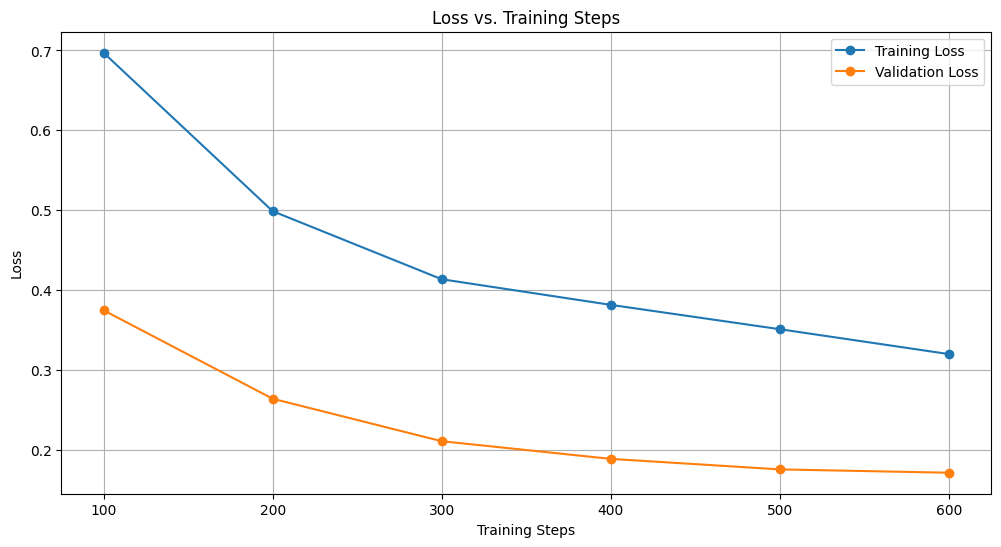

In [59]:
plt.figure(figsize=(12, 6))

# Plot training loss
plt.plot(train_steps, train_loss, label="Training Loss", marker='o', linestyle='-')

# Plot validation loss
plt.plot(val_steps, val_loss, label="Validation Loss", marker='o', linestyle='-')

# Labels & Title
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Loss vs. Training Steps")
plt.legend()
plt.grid()

# Show the plot
plt.show()

Based on the plot above, we can make the following observations

1. Training Loss is decreasing: This is to be expected because the model is learning from the training data
2. Validation Loss is decreasing: This shows that the model is generalising well to the unseen data
3. No signs of overfitting: Both losses decreasing at approximately the same rate shows that the model is fitting well and there are no concerns of underfitting or overfitting

Overall, I can conclude that the fine-tuning produced desirable results as both losses started to plateau when it is between the range of 500 and 600 steps

## Evaluation

Now, using the model that I have fine-tuned I will generated the predicted transcripts on the ```cv-valid-test``` dataset and compare the performance of the WER with the transcribed results in ```cv-valid-dev``` in task 2d

So now, we first run the cell to load the model from my HuggingFace Repository

In [74]:
# My Hugging Face Hub model name
MY_MODEL_NAME = "enlihhhhh/wav2vec2-large-960h-cv"

# Load the fine-tuned model and processor
processor = Wav2Vec2Processor.from_pretrained(MY_MODEL_NAME)
model = Wav2Vec2ForCTC.from_pretrained(MY_MODEL_NAME)

# Move model to GPU if available
model.to(device)

loading configuration file preprocessor_config.json from cache at /home/enlih/.cache/huggingface/hub/models--enlihhhhh--wav2vec2-large-960h-cv/snapshots/79392fc900f9e353ff026e8eb47922dcc8857d27/preprocessor_config.json
Feature extractor Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "Wav2Vec2Processor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}

loading file vocab.json from cache at /home/enlih/.cache/huggingface/hub/models--enlihhhhh--wav2vec2-large-960h-cv/snapshots/79392fc900f9e353ff026e8eb47922dcc8857d27/vocab.json
loading file tokenizer_config.json from cache at /home/enlih/.cache/huggingface/hub/models--enlihhhhh--wav2vec2-large-960h-cv/snapshots/79392fc900f9e353ff026e8eb47922dcc8857d27/tokenizer_config.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /ho

Wav2Vec2ForCTC(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder)

We then load the dataset into a Pandas dataframe

In [62]:
# Read in the test dataset
dev_common_voice = pd.read_csv("data/cv-valid-dev.csv")
eval_common_voice = pd.read_csv("data/cv-valid-test.csv")
eval_common_voice.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-test/sample-000000.mp3,without the dataset the article is useless,1,0,NaN,NaN,NaN,NaN
1,cv-valid-test/sample-000001.mp3,i've got to go to him,1,0,twenties,male,NaN,NaN
2,cv-valid-test/sample-000002.mp3,and you know it,1,0,NaN,NaN,NaN,NaN
3,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of people sleeping in peace,4,0,twenties,male,us,NaN
4,cv-valid-test/sample-000004.mp3,hold your nose to keep the smell from disabling your motor functions,2,0,NaN,NaN,NaN,NaN


This function of transcribing the audio is following the one function in Task 2 when creating the ```asr_api.py```

In [63]:
def transcribe_audio(audio_path):
    try:
        # Read the audio file
        audio, sample_rate = sf.read(os.path.join('data',audio_path))

        # Resample if not already 16kHz
        if sample_rate != 16000:
            audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=16000)

        # Convert audio to tensor and move to same device as model
        input_values = processor(audio, return_tensors="pt", sampling_rate=16000).input_values.to(device)

        # Perform inference
        with torch.no_grad():
            logits = model(input_values).logits

        # Decode the logits
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]

        return transcription

    except Exception as e:
        print(f"Error transcribing {audio_path}: {str(e)}")
        return None

tqdm.pandas(desc="Transcribing Audio Files")

# Transcribe the audio files and add to "generated_text" column similar to Task 2d
eval_common_voice["generated_text"] = eval_common_voice["filename"].progress_apply(transcribe_audio)

Transcribing Audio Files: 100%|██████████| 3995/3995 [01:00<00:00, 65.90it/s]


In [64]:
# Convert the generated text into lowercase
eval_common_voice["generated_text"] = eval_common_voice["generated_text"].str.lower()
eval_common_voice.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration,generated_text
0,cv-valid-test/sample-000000.mp3,without the dataset the article is useless,1,0,NaN,NaN,NaN,NaN,without the dat as it the articles useles
1,cv-valid-test/sample-000001.mp3,i've got to go to him,1,0,twenties,male,NaN,NaN,i've got to go to him
2,cv-valid-test/sample-000002.mp3,and you know it,1,0,NaN,NaN,NaN,NaN,and you know it
3,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of people sleeping in peace,4,0,twenties,male,us,NaN,down below in the darknes were hundreds of people sleping in peace
4,cv-valid-test/sample-000004.mp3,hold your nose to keep the smell from disabling your motor functions,2,0,NaN,NaN,NaN,NaN,hold your nose to kep the smel from disabling your motov functions


In [70]:
# Function to calculate the Word Error Rate (WER)
def calculate_wer(row):
    try:
        # Calculate the WER
        wer = jiwer.wer(row["text"], row["generated_text"])
        return wer
    except Exception as e:
        return None

# Calculate the WER for each row for the eval dataset and dev dataset
eval_common_voice["wer"] = eval_common_voice.apply(calculate_wer, axis=1)
dev_common_voice["wer"] = dev_common_voice.apply(calculate_wer, axis=1)

eval_common_voice.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration,generated_text,wer
0,cv-valid-test/sample-000000.mp3,without the dataset the article is useless,1,0,NaN,NaN,NaN,NaN,without the dat as it the articles useles,0.857143
1,cv-valid-test/sample-000001.mp3,i've got to go to him,1,0,twenties,male,NaN,NaN,i've got to go to him,0.000000
2,cv-valid-test/sample-000002.mp3,and you know it,1,0,NaN,NaN,NaN,NaN,and you know it,0.000000
3,cv-valid-test/sample-000003.mp3,down below in the darkness were hundreds of people sleeping in peace,4,0,twenties,male,us,NaN,down below in the darknes were hundreds of people sleping in peace,0.166667
4,cv-valid-test/sample-000004.mp3,hold your nose to keep the smell from disabling your motor functions,2,0,NaN,NaN,NaN,NaN,hold your nose to kep the smel from disabling your motov functions,0.250000


In [71]:
dev_common_voice.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration,generated_text,wer
0,cv-valid-dev/sample-000000.mp3,be careful with your prognostications said the stranger,1,0,NaN,NaN,NaN,NaN,be careful with your prognostications said the stranger,0.000000
1,cv-valid-dev/sample-000001.mp3,then why should they be surprised when they see one,2,0,NaN,NaN,NaN,NaN,then why should they be surprised when they see one,0.000000
2,cv-valid-dev/sample-000002.mp3,a young arab also loaded down with baggage entered and greeted the englishman,2,0,NaN,NaN,NaN,NaN,a young arab also loaded down with baggage entered and greeted the englishman,0.000000
3,cv-valid-dev/sample-000003.mp3,i thought that everything i owned would be destroyed,3,0,NaN,NaN,NaN,NaN,i felt that everything i owned would be destroyed,0.111111
4,cv-valid-dev/sample-000004.mp3,he moved about invisible but everyone could hear him,1,0,fourties,female,england,NaN,he moved about invisible but every one could hear him,0.222222


In [72]:
print("====== Overall Average WER Results Comparison ======")
print(f"cv-valid-dev (From task 2d) WER: {round(dev_common_voice['wer'].mean(),4) * 100}%")
print(f"cv-valid-test WER: {round(eval_common_voice['wer'].mean(),4) * 100}%")

====== Overall Average WER Results Comparison ======
cv-valid-dev (From task 2d) WER: 11.74%
cv-valid-test WER: 18.93%


In [73]:
# Save both dataframes into CSV files
dev_common_voice.to_csv("cv-valid-dev.csv", index=False)
eval_common_voice.to_csv("cv-valid-test.csv", index=False)

```txt
Answer for task 3c: 
Within your jupyter notebook, cv-train-2a.ipynb, in task 2d, use your
fine-tuned AI model to transcribe the common-voice mp3 files under cv-validtest and compare the generated text against cv-valid-test.csv. Log
your overall performance
```

We can see that the original ```facebook/wav2vec2-large-960h``` model which transcribed the audio into the results for cv-valid-dev has an average **11.74% Word Error Rate** which was much lower as compared to my fine-tuned model ```enlihhhhh/wav2vec2-large-960h-cv``` which has an average **18.93% Word Error Rate**.

## Conclusion

Overall, we can see that my model did not perform better than the original Wav2Vec2 model which could be due to following reasons:

1. ```Model was fine-tuned on only 10% of data:``` Due to my lack of computational resources, I only took a random sample of 10% of training data to fine-tune my model, however being able to achieve a WER of 22.06% shows that the fine-tuning did not overfit on the data.
2. ```Lack of diverse speech in training data:```: The dataset used for fine-tuning may not cover enough variations in accents, speaking speeds, or background noise. The original Wav2Vec2 model was trained on a much larger dataset with diverse speech, giving it an advantage in real-world scenarios.
3. ```Overfitting to the fine-tuning dataset:```: Since only 10% of data was used for fine-tuning, the model may have memorized specific speech patterns without generalizing well to unseen test samples. This could explain why the WER on cv-valid-test is higher as compared to the original model.

### References I referred to during my Fine-Tuning
1. [Official Research by Meta AI](https://ai.meta.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/)
2. [HuggingFace Resouces on wav2vec2](https://huggingface.co/docs/transformers/en/model_doc/wav2vec2)
3. [Wav2Vec2 Research Paper](https://arxiv.org/pdf/2006.11477)

###